In [1]:
import os
import gzip
import subprocess
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def get_df(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [3]:
DATASET = 'Grocery_and_Gourmet_Food'
SUB_PATH = "tada"
RAW_PATH = os.path.join('./', DATASET)
DATA_FILE = 'reviews_{}_5.json.gz'.format(DATASET)
META_FILE = 'meta_{}.json.gz'.format(DATASET)

# Load Data

1. Load interaction data and item metadata
2. Filter out unuseful items
3. Calculate basic statistics

In [4]:
# download data if not exists

if not os.path.exists(RAW_PATH):
    subprocess.call('mkdir ' + RAW_PATH, shell=True)
if not os.path.exists(os.path.join(RAW_PATH, DATA_FILE)):
    print('Downloading interaction data into ' + RAW_PATH)
    subprocess.call(
        'cd {} && curl -O http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_{}_5.json.gz'
        .format(RAW_PATH, DATASET), shell=True)
if not os.path.exists(os.path.join(RAW_PATH, META_FILE)):
    print('Downloading item metadata into ' + RAW_PATH)
    subprocess.call(
        'cd {} && curl -O http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_{}.json.gz'
        .format(RAW_PATH, DATASET), shell=True)

In [5]:
data_df = get_df(os.path.join(RAW_PATH, DATA_FILE))
data_df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1VEELTKS8NLZB,616719923X,Amazon Customer,"[0, 0]",Just another flavor of Kit Kat but the taste i...,4.0,Good Taste,1370044800,"06 1, 2013"
1,A14R9XMZVJ6INB,616719923X,amf0001,"[0, 1]",I bought this on impulse and it comes from Jap...,3.0,"3.5 stars, sadly not as wonderful as I had hoped",1400457600,"05 19, 2014"
2,A27IQHDZFQFNGG,616719923X,Caitlin,"[3, 4]",Really good. Great gift for any fan of green t...,4.0,Yum!,1381190400,"10 8, 2013"
3,A31QY5TASILE89,616719923X,DebraDownSth,"[0, 0]","I had never had it before, was curious to see ...",5.0,Unexpected flavor meld,1369008000,"05 20, 2013"
4,A2LWK003FFMCI5,616719923X,Diana X.,"[1, 2]",I've been looking forward to trying these afte...,4.0,"Not a very strong tea flavor, but still yummy ...",1369526400,"05 26, 2013"


In [6]:
meta_df = get_df(os.path.join(RAW_PATH, META_FILE))
meta_df.head()

,asin,description,title,imUrl,related,salesRank,categories,price,brand
0,0657745316,This is real vanilla extract made with only 3 ...,100 Percent All Natural Vanilla Extract,http://ecx.images-amazon.com/images/I/41gFi5h0...,{'also_viewed': ['B001GE8N4Y']},{'Grocery & Gourmet Food': 374004},[[Grocery & Gourmet Food]],NaN,NaN
1,0700026444,"Silverpot Tea, Pure Darjeeling, is an exquisit...",Pure Darjeeling Tea: Loose Leaf,http://ecx.images-amazon.com/images/I/51hs8sox...,NaN,{'Grocery & Gourmet Food': 620307},[[Grocery & Gourmet Food]],NaN,NaN
2,1403796890,Must have for any WWE Fan\n \n \n \nFeaturing ...,WWE Kids Todler Velvet Slippers featuring John...,http://ecx.images-amazon.com/images/I/518SEST5...,NaN,NaN,[[Grocery & Gourmet Food]],3.99,NaN
3,141278509X,Infused with Vitamins and Electrolytes Good So...,Archer Farms Strawberry Dragonfruit Drink Mix ...,http://ecx.images-amazon.com/images/I/51CFQIis...,{'also_viewed': ['B0051IETTY']},{'Grocery & Gourmet Food': 620322},[[Grocery & Gourmet Food]],NaN,NaN
4,1453060375,MiO Energy is your portable energy source givi...,Mio Energy Liquid Water Enhancer Black Cherry ...,http://ecx.images-amazon.com/images/I/51EUsMcn...,"{'also_viewed': ['B006MSEOJ2', 'B005VOOQLO', '...",{'Grocery & Gourmet Food': 268754},[[Grocery & Gourmet Food]],11.99,Mio


In [7]:
# Filter items

useful_meta_df = meta_df[meta_df['asin'].isin(data_df['asin'])]
items_with_info = useful_meta_df['related'].apply(lambda x: x is not np.nan)
useful_meta_df = useful_meta_df[items_with_info].reset_index(drop=True)

all_items = set(useful_meta_df['asin'].values.tolist())
def related_filter(related_dict):
    out_dict = dict()
    for r in related_dict:
        out_dict[r] = list(all_items & set(related_dict[r]))
    return out_dict

useful_meta_df['related'] = useful_meta_df['related'].apply(related_filter)
data_df = data_df[data_df['asin'].isin(all_items)]

### Statistics

In [8]:
n_users = data_df['reviewerID'].value_counts().size
n_items = data_df['asin'].value_counts().size
n_clicks = len(data_df)
min_time = data_df['unixReviewTime'].min()
max_time = data_df['unixReviewTime'].max()

In [9]:
time_format = '%Y-%m-%d'

print('# Users:', n_users)
print('# Items:', n_items)
print('# Interactions:', n_clicks)
print('Time Span: {}/{}'.format(
    datetime.utcfromtimestamp(min_time).strftime(time_format),
    datetime.utcfromtimestamp(max_time).strftime(time_format))
)

# Users: 14680
# Items: 8456
# Interactions: 145832
Time Span: 2000-08-09/2014-07-23


### Data Interval

In [17]:
review_day = data_df.unixReviewTime/86400

In [18]:
review_day_norm = review_day - review_day.min()

In [19]:
review_day.max(), review_day.min(), review_day.max() - review_day.min()

(16274.0, 11178.0, 5096.0)

In [23]:
import matplotlib.pyplot as plt

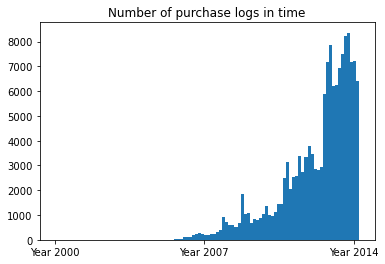

In [99]:
# plot the number of logs in timeline
plt.hist(review_day_norm, bins=100)
plt.xticks([0, 2500, 5000], ["Year 2000", "Year 2007", "Year 2014"])
plt.title("Number of purchase logs in time")
plt.show()

### Interaction data

In [44]:
np.random.seed(2019)
NEG_ITEMS = 99

In [45]:
out_df = data_df.rename(columns={'asin': 'item_id', 'reviewerID': 'user_id', 'unixReviewTime': 'time'})
out_df = out_df[['user_id', 'item_id', 'time']]
out_df = out_df.drop_duplicates(['user_id', 'item_id', 'time'])
out_df.sort_values(by=['time', 'user_id', 'item_id'], inplace=True)
out_df.head()

,user_id,item_id,time
35,A1KXONFPU2XQ5K,B00004S1C5,965779200
136,A23GFTVIETX7DS,B0000CH39R,1068249600
171,A281NPSIMI1C2R,B0000DBN1H,1073433600
55,A3M174IC0VXOS2,B0000537AF,1075593600
1413,A218J1WI08045B,B0001EQN88,1082073600


In [46]:
# reindex (start from 1)

uids = sorted(out_df['user_id'].unique())
user2id = dict(zip(uids, range(1, len(uids) + 1)))
iids = sorted(out_df['item_id'].unique())
item2id = dict(zip(iids, range(1, len(iids) + 1)))

out_df['user_id'] = out_df['user_id'].apply(lambda x: user2id[x])
out_df['item_id'] = out_df['item_id'].apply(lambda x: item2id[x])
out_df = out_df.reset_index(drop=True)
out_df.head()

,user_id,item_id,time
0,2177,3,965779200
1,4161,18,1068249600
2,4698,23,1073433600
3,10145,6,1075593600
4,3915,125,1082073600


## User purchase intervals

In [103]:
from collections import defaultdict

user_review_intervals = defaultdict()
user_review_total_span = []
user_review_total_length = []
for user_id, seq_df in out_df.groupby("user_id"):
    user_review_intervals[user_id] = ((seq_df['time'] - seq_df['time'].shift())[1:])/86400
    user_review_total_span.append((seq_df['time'].iloc[-1] - seq_df['time'].iloc[0])/86400)
    user_review_total_length.append(len(seq_df))

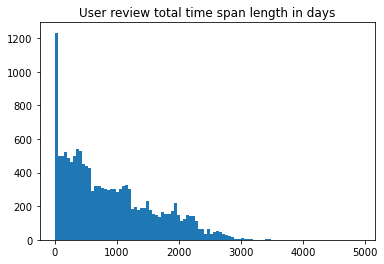

In [222]:
plt.hist(user_review_total_span, bins=100)
plt.title("User review total time span length in days")
plt.show()

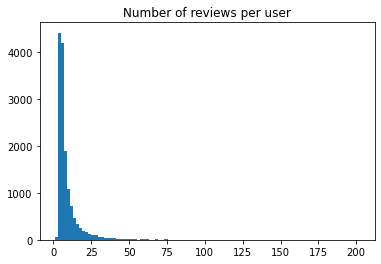

In [140]:
plt.hist(user_review_total_length, bins=100)
plt.title("Number of reviews per user")
plt.show()

In [175]:
def print_ratio(array, k):
    ratio = int((len(array[array<k])/len(array))*100)
    print("Ratio of users with review counts less than %(k)2.2s: %(ratio)2.2s%%" % locals())

total_length = np.array(user_review_total_length)
print_ratio(total_length, 5)
print_ratio(total_length, 10)
print_ratio(total_length, 15)
print_ratio(total_length, 20)
print_ratio(total_length, 25)
print_ratio(total_length, 50)

Ratio of users with review counts less than  5:  2%
Ratio of users with review counts less than 10: 72%
Ratio of users with review counts less than 15: 85%
Ratio of users with review counts less than 20: 91%
Ratio of users with review counts less than 25: 94%
Ratio of users with review counts less than 50: 98%


In [137]:
user_review_average_intervals =  [v.mean() for k, v in user_review_intervals.items()]
user_review_nonzero_average_intervals =  [v[v!=0].mean() for k, v in user_review_intervals.items()]

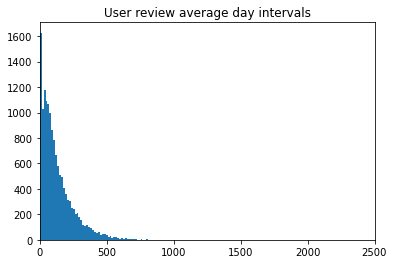

In [144]:
plt.hist(user_review_average_intervals, bins=100)
plt.title("User review average day intervals")
plt.xlim(0,2500)
plt.show()

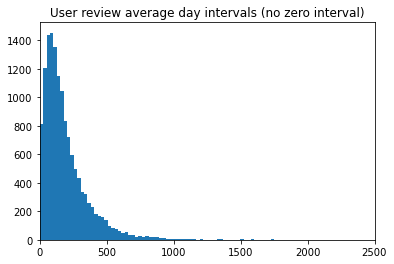

In [147]:
plt.hist(user_review_nonzero_average_intervals, bins=100)
plt.title("User review average day intervals (no zero interval)")
plt.xlim(0,2500)
plt.show()

In [180]:
def print_interval_ratio(array, k):
    ratio = int((len(array[array<k])/len(array))*100)
    print("Ratio of users with intervals less than %(k)4.4s: %(ratio)2.2s%%" % locals())

total_length = np.array(user_review_average_intervals)
print_interval_ratio(total_length, 10)
print_interval_ratio(total_length, 20)
print_interval_ratio(total_length, 50)
print_interval_ratio(total_length, 100)
print_interval_ratio(total_length, 500)
print_interval_ratio(total_length, 1000)

Ratio of users with intervals less than   10:  8%
Ratio of users with intervals less than   20: 13%
Ratio of users with intervals less than   50: 29%
Ratio of users with intervals less than  100: 52%
Ratio of users with intervals less than  500: 98%
Ratio of users with intervals less than 1000: 99%


<ipython-input-180-2f0c23be9571>:2: RuntimeWarning: invalid value encountered in less
  ratio = int((len(array[array<k])/len(array))*100)


In [189]:
user_review_days = defaultdict()
min_day = out_df['time'].min()/86400 
for user_id, seq_df in out_df.groupby("user_id"):
    user_review_days[user_id] = seq_df['time']/86400 - min_day    

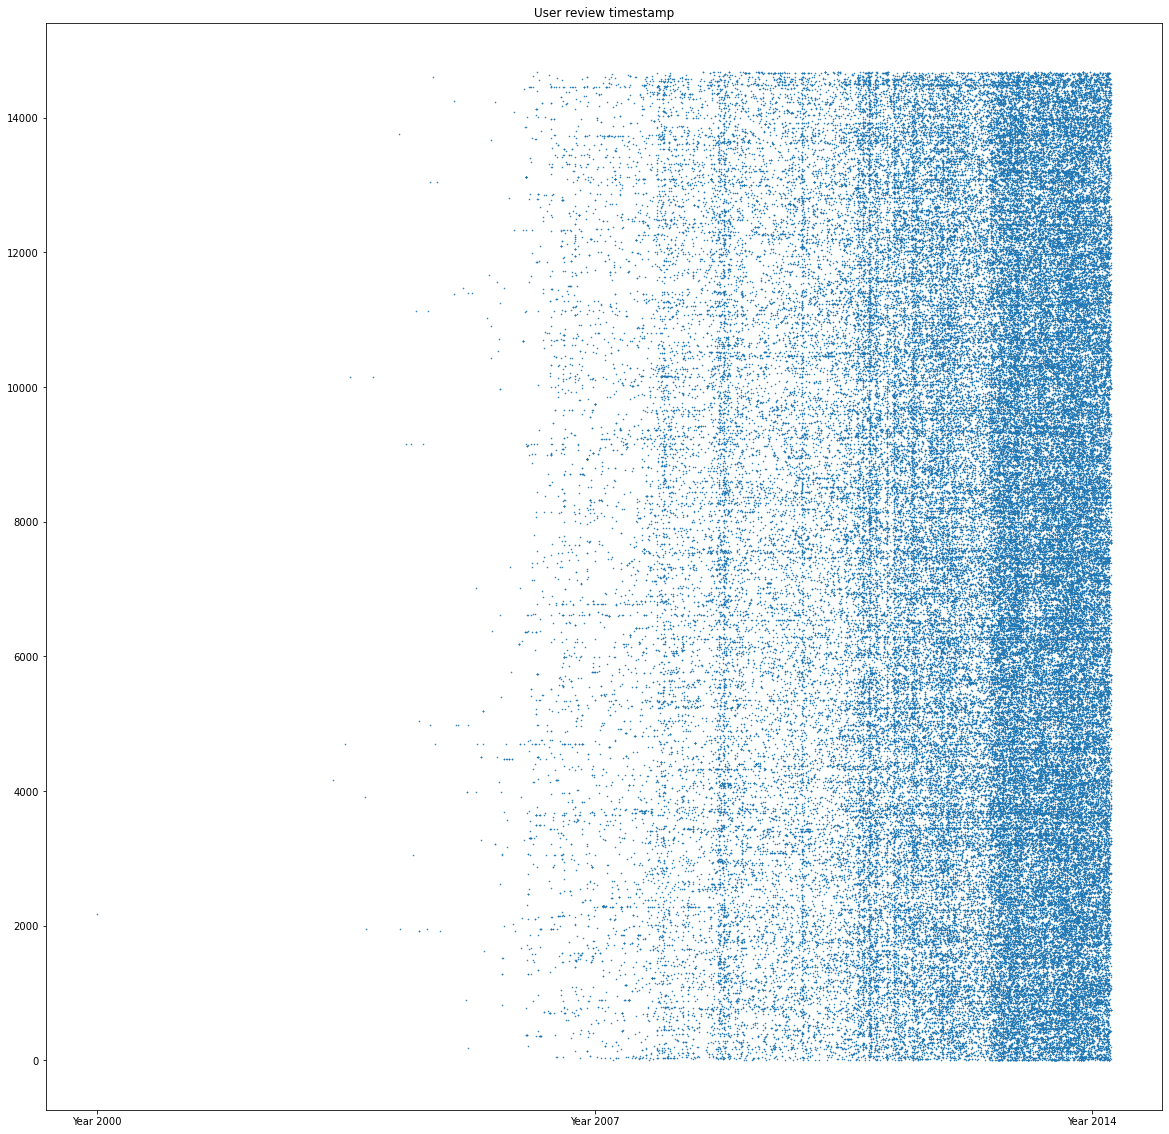

In [226]:
review_x = []
review_y = []
for i, v in user_review_days.items():
    review_x.extend(v.values)
    review_y.extend([i]*len(v))
plt.figure(figsize=(20,20))
plt.scatter(review_x, review_y, 0.3)
plt.title("User review timestamp")
plt.xticks([0, 2500, 5000], ["Year 2000", "Year 2007", "Year 2014"])
plt.show()

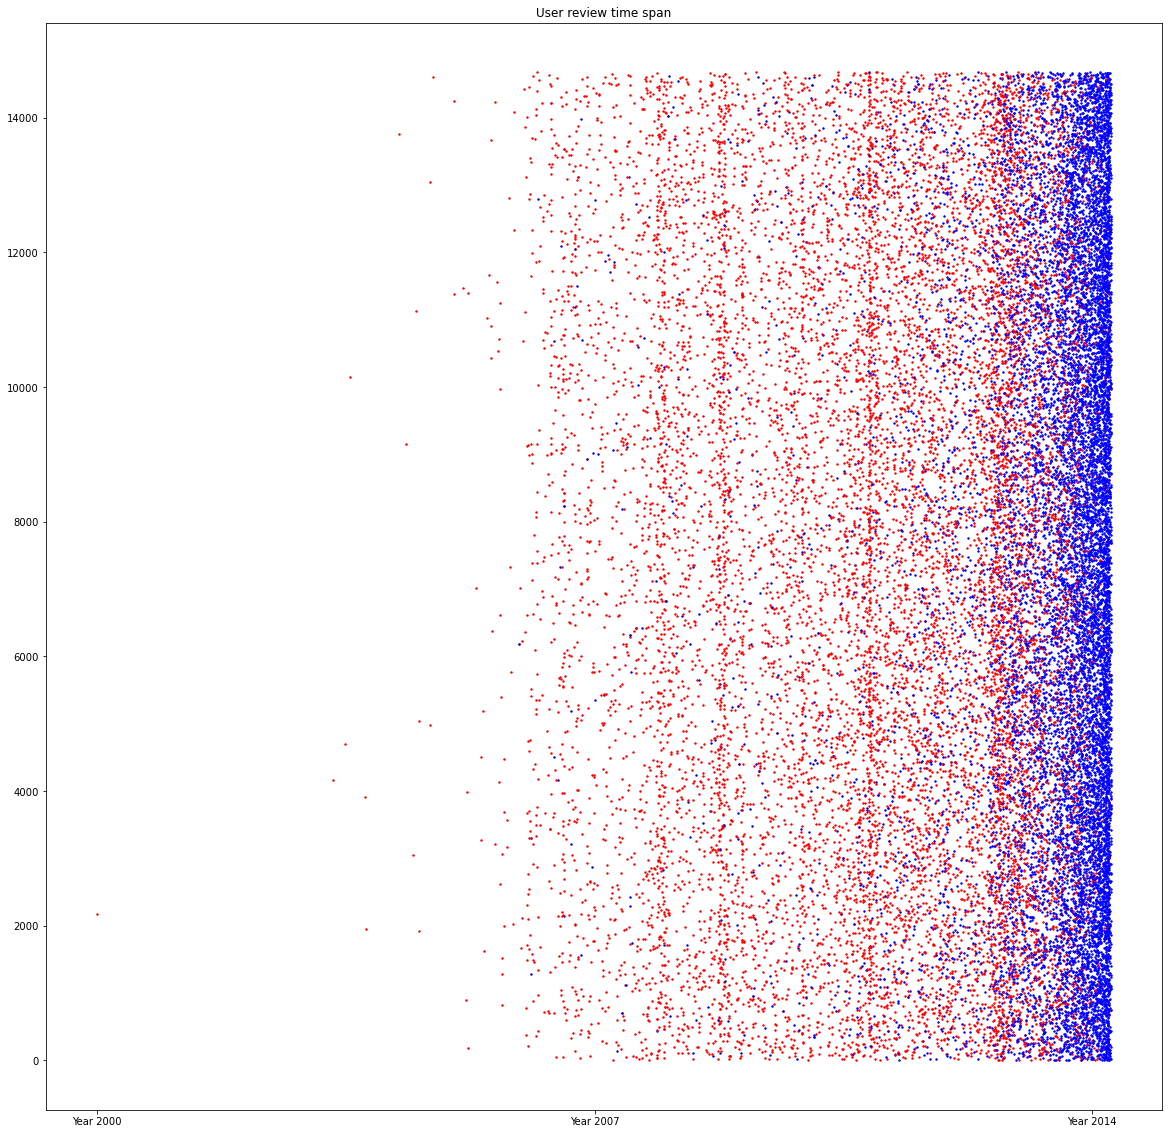

In [236]:
plt.figure(figsize=(20,20))
for i, v in user_review_days.items():
    plt.scatter(v.iloc[0], i, 2, c='red')
    plt.scatter(v.iloc[-1], i, 2, c='blue')
    #plt.hlines(i, v.iloc[0], v.iloc[-1], lw=0.3)
    
plt.title("User review time span")
plt.xticks([0, 2500, 5000], ["Year 2000", "Year 2007", "Year 2014"])
plt.show()

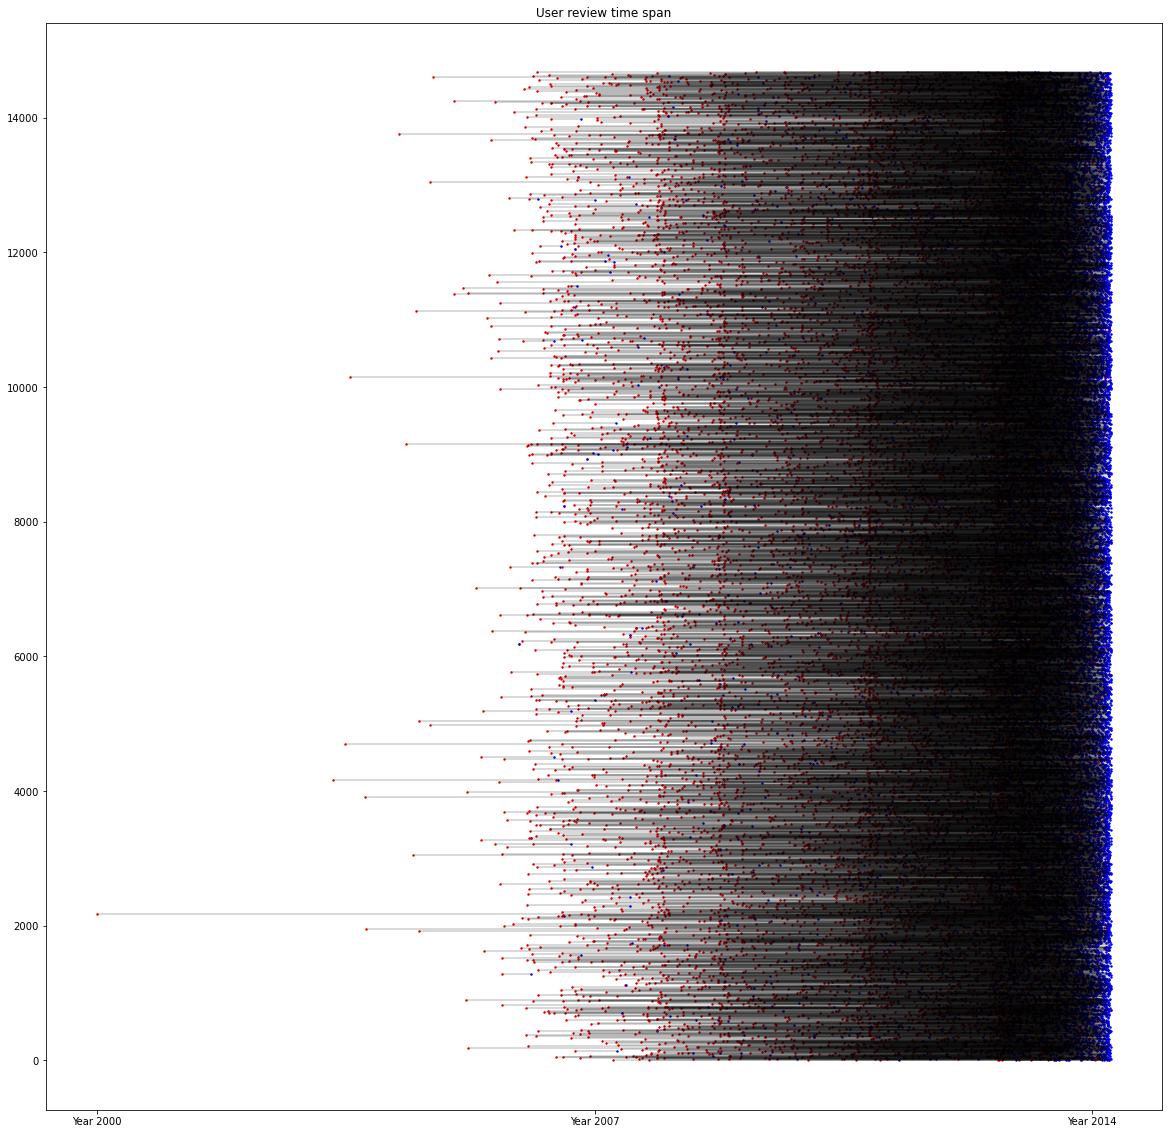

In [235]:
plt.figure(figsize=(20,20))
for i, v in user_review_days.items():
    plt.scatter(v.iloc[0], i, 2, c='red')
    plt.scatter(v.iloc[-1], i, 2, c='blue')
    plt.hlines(i, v.iloc[0], v.iloc[-1], lw=0.3)
    
plt.title("User review time span")
plt.xticks([0, 2500, 5000], ["Year 2000", "Year 2007", "Year 2014"])
plt.show()

# Build Dataset

In [232]:
# leave one out spliting

clicked_item_set = dict()
for user_id, seq_df in out_df.groupby('user_id'):
    clicked_item_set[user_id] = set(seq_df['item_id'].values.tolist())

In [255]:
def generate_dev_test(data_df):
    result_dfs = []
    for idx in range(2):
        result_df = data_df.groupby('user_id').tail(1).copy()
        data_df = data_df.drop(result_df.index)
        neg_items = np.random.randint(1, len(iids) + 1, (len(result_df), NEG_ITEMS))
        for i, uid in enumerate(result_df['user_id'].values):
            user_clicked = clicked_item_set[uid]
            for j in range(len(neg_items[i])):
                while neg_items[i][j] in user_clicked:
                    neg_items[i][j] = np.random.randint(1, len(iids) + 1)
        result_df['neg_items'] = neg_items.tolist()
        result_dfs.append(result_df)
    return result_dfs, data_df

In [259]:
def generate_multitest(data_df, k):
    result_dfs = []
    for idx in range(k):
        result_df = data_df.groupby('user_id').tail(1).copy()
        data_df = data_df.drop(result_df.index)
        neg_items = np.random.randint(1, len(iids) + 1, (len(result_df), NEG_ITEMS))
        for i, uid in enumerate(result_df['user_id'].values):
            user_clicked = clicked_item_set[uid]
            for j in range(len(neg_items[i])):
                while neg_items[i][j] in user_clicked:
                    neg_items[i][j] = np.random.randint(1, len(iids) + 1)
        result_df['neg_items'] = neg_items.tolist()
        result_dfs.insert(0, result_df)
        
    return result_dfs, data_df

In [260]:
k=10

In [261]:
leave_df = out_df.groupby('user_id').head(1)
data_df = out_df.drop(leave_df.index)

test_df, data_df = generate_multitest(data_df, k)
train_df = pd.concat([leave_df, data_df]).sort_index()

(51155, 3497)

In [263]:
len(train_df), len(test_df[0]), len(test_df[9])

(51155, 3497, 14676)

In [265]:
# save results

train_df.to_csv(os.path.join(RAW_PATH, SUB_PATH, 'train.csv'), sep='\t', index=False)
# dev_df.to_csv(os.path.join(RAW_PATH, SUB_PATH, 'dev.csv'), sep='\t', index=False)
for i in range(k):
    test_df[i].to_csv(os.path.join(RAW_PATH, SUB_PATH, 'test' + str(i) + '.csv'), sep='\t', index=False)

### Item Metadata (Not dependent to user purchase history)

In [ ]:
# l2 category

l2_cate_lst = list()
for cate_lst in useful_meta_df['categories']:
    l2_cate_lst.append(cate_lst[0][2] if len(cate_lst[0]) > 2 else np.nan)
useful_meta_df['l2_category'] = l2_cate_lst  
l2_cates = sorted(useful_meta_df['l2_category'].dropna().unique())
l2_dict = dict(zip(l2_cates, range(1, len(l2_cates) + 1)))
useful_meta_df['l2_category'] = useful_meta_df['l2_category'].apply(lambda x: l2_dict[x] if x == x else 0)

In [ ]:
item_meta_data = dict()
for idx in range(len(useful_meta_df)):
    info = useful_meta_df.iloc[idx]['related']
    item_meta_data[idx] = {
        'item_id': item2id[useful_meta_df.iloc[idx]['asin']],
        'category': useful_meta_df.iloc[idx]['l2_category'],
        'r_complement': list(map(lambda x: item2id[x], info['also_bought'])) if 'also_bought' in info else [],
        'r_substitute': list(map(lambda x: item2id[x], info['also_viewed'])) if 'also_viewed' in info else [],
    }

item_meta_df = pd.DataFrame.from_dict(item_meta_data, orient='index')
item_meta_df = item_meta_df[['item_id', 'category', 'r_complement', 'r_substitute']]
item_meta_df.head()

In [ ]:
# save results

item_meta_df.to_csv(os.path.join(RAW_PATH, SUB_PATH, 'item_meta.csv'), sep='\t', index=False)

In [284]:
a = defaultdict(list)

In [285]:
a['test1'].extend(range(10))
a['test2'].extend(range(40,50))
a['test3'].extend(range(10,20))

In [289]:
a.values()

dict_values([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [40, 41, 42, 43, 44, 45, 46, 47, 48, 49], [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]])

In [297]:
pd.DataFrame(a).to_csv("./hi.csv", index=False)

In [ ]:
b.to_csv()

In [298]:
bb = pd.read_csv("./hi.csv")

In [299]:
bb

,test1,test2,test3
0,0,40,10
1,1,41,11
2,2,42,12
3,3,43,13
4,4,44,14
5,5,45,15
6,6,46,16
7,7,47,17
8,8,48,18
9,9,49,19


In [287]:
import pandas as pd

df = pd.DataFrame([[k] + v[0] for k, v in a.items()], 
                   columns=['id', 'score', 'category'])

TypeError: can only concatenate list (not "int") to list